path train: '/kaggle/input/indonesian-food/dataset/train'<br>
path test: '/kaggle/input/indonesian-food/dataset/test'<br>
path valid: '/kaggle/input/indonesian-food/dataset/valid'<br>
ada 5 kelas: bakso gado gudeg rendang sate

In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from PIL import Image
# import os
# import numpy as np
# # Let's check size of images
# base_dir = '/kaggle/input/indonesian-food/dataset/train/bakso'
# for image in list(os.walk("/kaggle/input/indonesian-food/dataset/train/bakso"))[0][2]:
#   a = Image.open(os.path.join(base_dir, image))
#   print(np.asarray(a).shape)

In [2]:
import tensorflow as tf

print('\\u2022 Using TensorFlow Version:', tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\u2022 Using TensorFlow Version: 2.11.0


In [3]:
# import os

# base_dir = '/kaggle/input/indonesian-food/dataset/train'

# bakso_dir = os.path.join(base_dir, 'bakso')
# gado_dir = os.path.join(base_dir, 'gado')
# gudeg_dir = os.path.join(base_dir, 'gudeg')
# rendang_dir = os.path.join(base_dir, 'rendang')
# sate_dir = os.path.join(base_dir, 'sate')

# print('total training bakso images:', len(os.listdir(bakso_dir)))
# print('total training gado images:', len(os.listdir(gado_dir)))
# print('total training gudeg images:', len(os.listdir(gudeg_dir)))
# print('total training rendang images:', len(os.listdir(rendang_dir)))
# print('total training sate images:', len(os.listdir(sate_dir)))

# bakso_files = os.listdir(bakso_dir)
# print(bakso_files[:10])

# gado_files = os.listdir(gado_dir)
# print(gado_files[:10])

# gudeg_files = os.listdir(gudeg_dir)
# print(gudeg_files[:10])

# rendang_files = os.listdir(rendang_dir)
# print(rendang_files[:10])

# sate_files = os.listdir(sate_dir)
# print(sate_files[:10])

In [4]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow.keras.layers as tflayers

# Model Training
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import tensorflow.keras.layers as tflayers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Model Hypertunning
!pip install -q keras_tuner
!pip install Keras-Preprocessing
cls()
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ['bakso', 'gado', 'rendang', 'sate']

In [6]:
# with tf.device('/gpu:0'):
model = Sequential()

# base_model = Xception(
#     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
#     include_top=False,
#     weights='imagenet'
# )
# model.add(base_model)
# model.add(tf.keras.layers.GlobalAveragePooling2D())

# nontransfer learning
model.add(tflayers.RandomFlip("horizontal_and_vertical"))
model.add(tflayers.RandomRotation(0.2))
model.add(tflayers.Rescaling(1./255, offset=-1))
model.add(tflayers.Conv2D(32, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(64, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))

model.add(tflayers.Conv2D(128, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Flatten())

# Tune the hyperparameters for the Dense layer
model.add(Dense(512, activation='relu'))
model.add(tflayers.Dropout(0.2))
model.add(Dense(4, activation='softmax'))

initial_LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_LR)
new_learning_rate = 9e-4
optimizer.learning_rate.assign(new_learning_rate)

model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)

# Print the model summary


In [7]:
# model.summary()

In [8]:
TRAINING_DIR = "/kaggle/input/indonesian-food/dataset/train"
VALIDATION_DIR = "/kaggle/input/indonesian-food/dataset/test"

train_generator = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
    
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
    
)

Found 7754 files belonging to 4 classes.
Found 866 files belonging to 4 classes.


In [9]:
# Perform hyperparameter tuning
# tuner.search(
#     train_generator, 
#     validation_data=validation_generator, 
#     epochs=10
# #     steps_per_epoch=100
# )

# Get the best hyperparameters and build the final model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# with tf.device('/gpu:0'):
# Train the model
history = model.fit(
    train_generator, 
    epochs=50, 
    verbose=1, 
    validation_data = validation_generator
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
243/243 [==============================] - 49s 153ms/step - loss: 1.1200 - accuracy: 0.4828 - val_loss: 0.8648 - val_accuracy: 0.6236
Epoch 2/50
243/243 [==============================] - 35s 141ms/step - loss: 0.8641 - accuracy: 0.6322 - val_loss: 0.9708 - val_accuracy: 0.5670
Epoch 3/50
243/243 [==============================] - 35s 140ms/step - loss: 0.7439 - accuracy: 0.6964 - val_loss: 0.6404 - val_accuracy: 0.7552
Epoch 4/50
243/243 [==============================] - 34s 140ms/step - loss: 0.6967 - accuracy: 0.7236 - val_loss: 0.6115 - val_accuracy: 0.7552
Epoch 5/50
243/243 [==============================] - 34s 140ms/step - loss: 0.6332 - accuracy: 0.7514 - val_loss: 0.5469 - val_accuracy: 0.7968
Epoch 6/50
243/243 [==============================] - 36s 145ms/step - loss: 0.5757 - accuracy: 0.7761 - val_loss: 0.4529 - val_accuracy: 0.8268
Epoch 7/50
243/243 [==============================] - 34s 139ms/step - loss: 0.5133 - accuracy: 0.7956 - val_loss: 0.4360 - val_ac

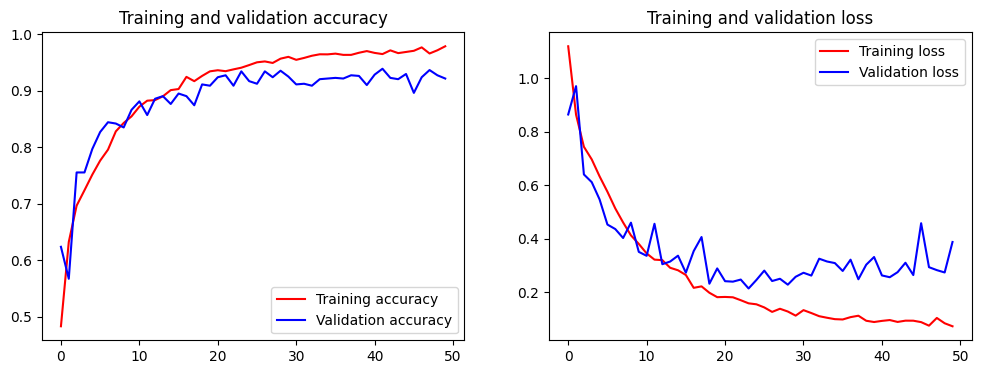

In [11]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [12]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoints', options=save_locally)

In [13]:
# hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
historyFinal = model.fit(
    train_generator, 
    epochs=best_epoch, 
    verbose=1,
    validation_data = validation_generator,
    callbacks=[checkpoints_cb]
)

Epoch 1/42
243/243 [==============================] - 39s 159ms/step - loss: 0.0606 - accuracy: 0.9798 - val_loss: 0.3213 - val_accuracy: 0.9145
Epoch 2/42
243/243 [==============================] - 39s 158ms/step - loss: 0.0817 - accuracy: 0.9738 - val_loss: 0.3055 - val_accuracy: 0.9169
Epoch 3/42
243/243 [==============================] - 39s 159ms/step - loss: 0.0742 - accuracy: 0.9730 - val_loss: 0.3580 - val_accuracy: 0.9203
Epoch 4/42
243/243 [==============================] - 39s 160ms/step - loss: 0.0516 - accuracy: 0.9826 - val_loss: 0.3218 - val_accuracy: 0.9296
Epoch 5/42
243/243 [==============================] - 39s 157ms/step - loss: 0.0733 - accuracy: 0.9742 - val_loss: 0.4066 - val_accuracy: 0.9180
Epoch 6/42
243/243 [==============================] - 40s 161ms/step - loss: 0.0828 - accuracy: 0.9716 - val_loss: 0.2988 - val_accuracy: 0.9273
Epoch 7/42
243/243 [==============================] - 39s 161ms/step - loss: 0.0834 - accuracy: 0.9721 - val_loss: 0.3406 - val_ac

In [14]:
# eval_result = hypermodel.evaluate(img_test, label_test)
# print("[test loss, test accuracy]:", eval_result)

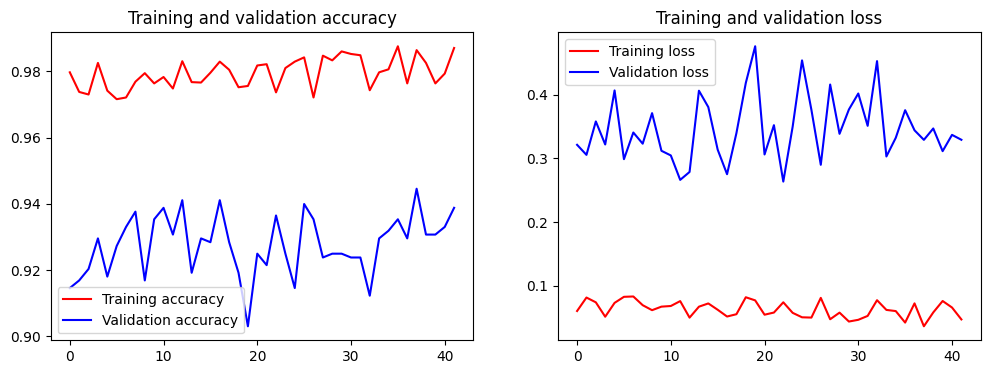

In [15]:
import matplotlib.pyplot as plt

# Plot the results
acc = historyFinal.history['accuracy']
val_acc = historyFinal.history['val_accuracy']
loss = historyFinal.history['loss']
val_loss = historyFinal.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [16]:
# Define the path to the directory where the checkpoints were saved
checkpoint_dir = './checkpoints'

# Load the best checkpoint using tf.keras.models.load_model()
best_model = tf.keras.models.load_model(checkpoint_dir)

In [17]:
from datetime import datetime
# current date and time
now = datetime.now()

time_stamp = datetime.timestamp(now)
name = f'model-train-{time_stamp}'
best_model.save(f'{name}.h5')

In [18]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model(
#     '/kaggle/input/models/model-train-1685459367.992634.h5'
# )

In [19]:
TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    batch_size=64,
    label_mode='categorical',
#     class_names=CLASS_NAMES,
    image_size=(224, 224),
    shuffle=False    
)

score = best_model.evaluate(test_dataset, verbose=0)
# score = loaded_model.evaluate(test_dataset, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 349 files belonging to 4 classes.
Test loss: 1.1581770181655884
Test accuracy: 0.8223495483398438


In [20]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

true_labels = np.concatenate([y for _, y in test_dataset], axis=0)

true_labels = to_categorical(true_labels, num_classes=4)

class_names = CLASS_NAMES
print(class_names)
 
# predicting images
TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'
for dirname, _, filenames in os.walk(TEST_DIR):
    if dirname is not TEST_DIR:
        last_dir = os.path.basename(os.path.normpath(dirname))
        correct = 0
        report = None
        for idx, filename in enumerate(filenames):
            path = filename

            img = load_img(os.path.join(
                os.path.join(TEST_DIR, dirname), filename), target_size=(IMAGE_SIZE, IMAGE_SIZE))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            images = np.vstack([x])
            classes = best_model.predict(images, batch_size=128, verbose=0)
#             classes = loaded_model.predict(images, batch_size=128, verbose=0)
            score = tf.nn.softmax(classes[0])
            
            predicted_class = np.argmax(score)
            predicted_class_name = class_names[np.argmax(score)]

            if(last_dir==predicted_class_name): correct += 1
#             print("Image: ", filename)
#             print(
#                 "This image most likely belongs to {} with a {:.2f} percent confidence.\n"
#                 .format(predicted_class_name, 100 * np.max(score))
#             )
    
        print(f'untuk folder {last_dir}')
        print("Jumlah data",len(os.listdir(os.path.join(TEST_DIR, dirname))))
        print("Jumlah data benar", correct)
        print(
            "Akurasi {:.2f}\n"
            .format(100*(correct/len(os.listdir(os.path.join(TEST_DIR, dirname)))))
        )


['bakso', 'gado', 'rendang', 'sate']
untuk folder sate
Jumlah data 89
Jumlah data benar 79
Akurasi 88.76

untuk folder bakso
Jumlah data 90
Jumlah data benar 72
Akurasi 80.00

untuk folder gado
Jumlah data 87
Jumlah data benar 68
Akurasi 78.16

untuk folder rendang
Jumlah data 83
Jumlah data benar 67
Akurasi 80.72



In [21]:
import numpy as np
import os
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

TEST_DIR = '/kaggle/input/indonesian-food/dataset/val'
CLASS_NAMES = ['bakso', 'gado', 'rendang', 'sate']
num_classes = len(CLASS_NAMES)

# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(CLASS_NAMES.index(class_name))
    return np.array(images), np.array(labels)

# Load the test images and labels
test_images, true_labels = load_images(TEST_DIR)

# Preprocess the true labels to one-hot encoded format
true_labels = to_categorical(true_labels, num_classes=num_classes)

# Get the predicted probabilities from the model
# predicted_probabilities = loaded_model.predict(test_images)
predicted_probabilities = best_model.predict(test_images)

# Convert the predicted probabilities to predicted labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels = to_categorical(predicted_labels, num_classes=num_classes)

# Compute the classification report for each class
report = classification_report(
    true_labels, 
    predicted_labels, 
    target_names=CLASS_NAMES, 
    digits=4,
#     output_dict=True
)

print(report)


11/11 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

       bakso     0.0000    0.0000    0.0000        90
        gado     0.0000    0.0000    0.0000        87
     rendang     0.2378    1.0000    0.3843        83
        sate     0.0000    0.0000    0.0000        89

   micro avg     0.2378    0.2378    0.2378       349
   macro avg     0.0595    0.2500    0.0961       349
weighted avg     0.0566    0.2378    0.0914       349
 samples avg     0.2378    0.2378    0.2378       349



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
